<a href="https://colab.research.google.com/github/gabrie1-s/Chagas_analysis/blob/main/Adaboost_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Aquisição dos dados

In [ ]:
!pip install --upgrade pip
!pip install mat73
!pip install scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/5c/e9/ee572691a3fb05555bcde41826faad29ae4bc1fb07982e7f53d54a176879/scikit_learn-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from google.colab import drive
import mat73
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import pdb
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = mat73.loadmat('/content/drive/MyDrive/CNN_Chagas/Chagas/data/Dataset_Raw.mat')

In [ ]:
signals = list(dataset['Dataset_Raw'])

output = []
for i in range(0, len(signals)):
    output.append(signals[i][-1])
    signals[i] = np.delete(signals[i], [-1,-2])
    # signals[i] = signals[i][0:1000]

In [ ]:
max = 10
for i, signal in enumerate(signals):
  count = 0
  for j, val in enumerate(signal):
    if val == 0:
      count += 1
    else:
      count = 0

    if count == max:
      signals[i] = signal[0: j-max+1]
      break

In [ ]:
d = {'signals': signals, 'output': output}
df = pd.DataFrame(data=d)

# 2. Aplicação da transformada wavelet

In [ ]:
def gera_filtro_MH(Escala):
  passo = 1/Escala
  X = []
  a = -5
  X.append(a)
  while a <= 5:
    a=a+passo
    X.append(a)
  Y = []
  for i in range(0,len(X)):
    Y.append(2.1741*(1/math.sqrt(2*math.pi) * (1 - X[i]**2) * np.exp(-X[i]**2/(2))))
  return Y

def apply_wavelet(signal, level):
  Filtro = gera_filtro_MH(level)
  y = np.convolve(signal,Filtro)
  return y

In [ ]:
test_sig = random.choices(signals, k=5)

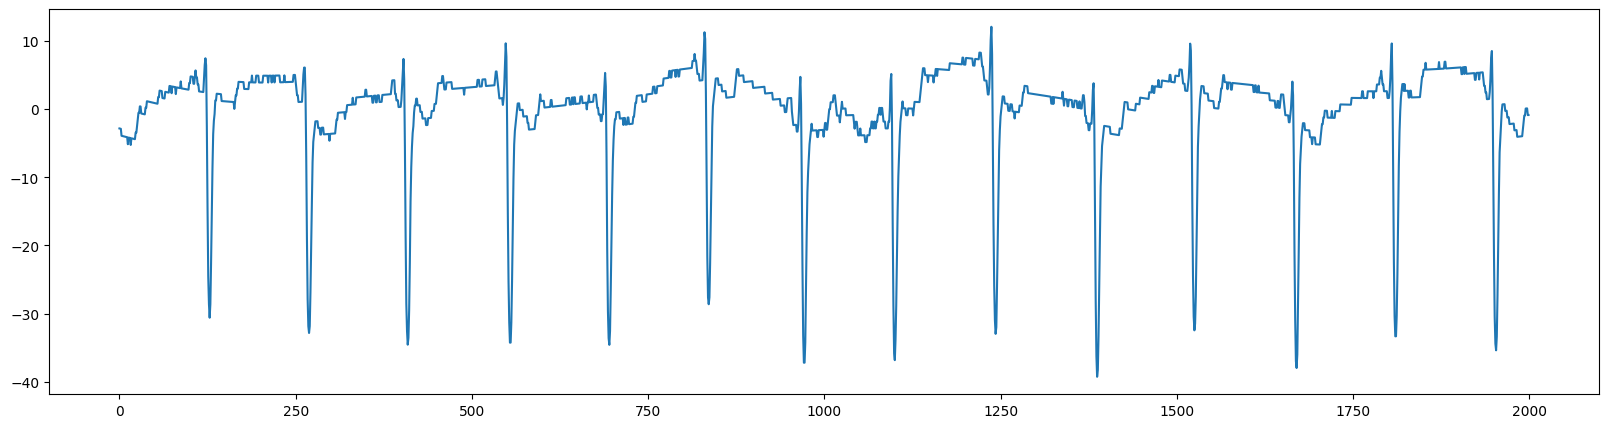

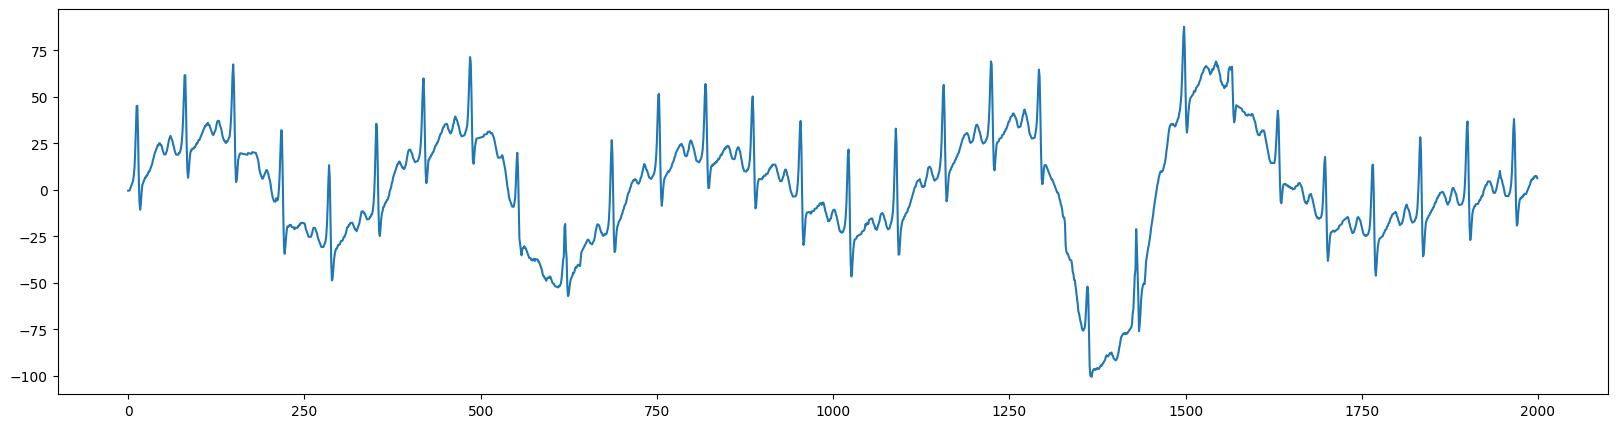

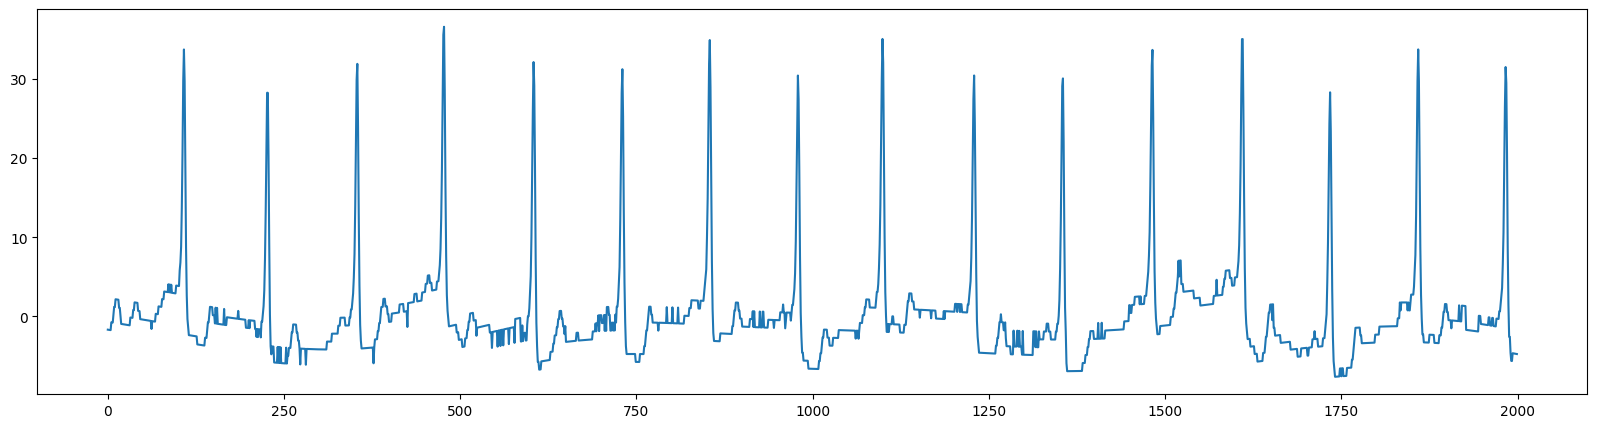

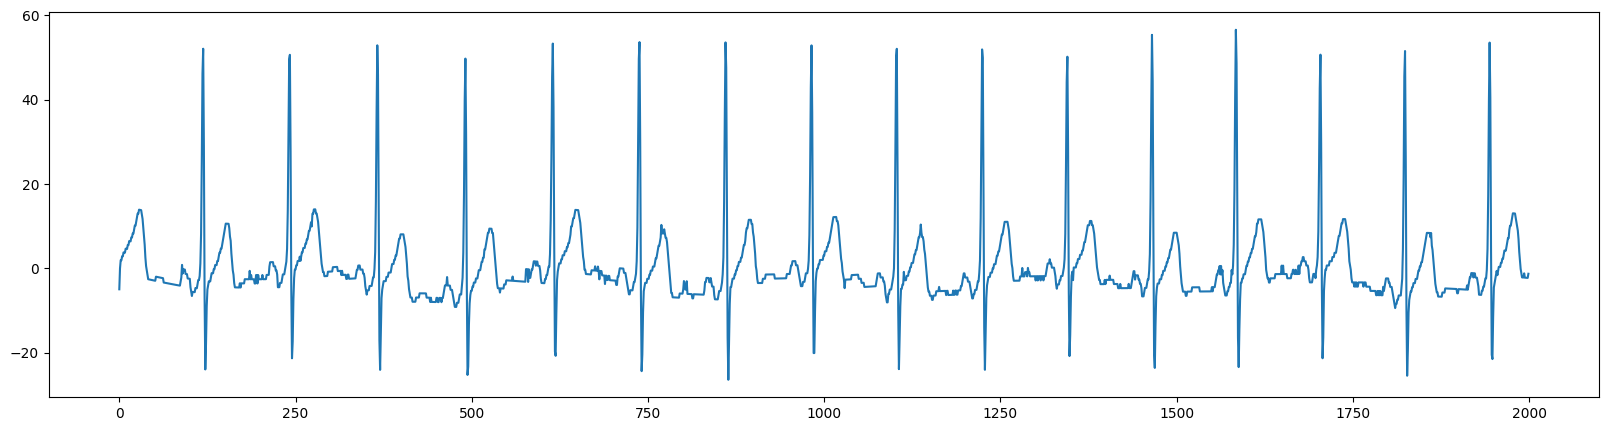

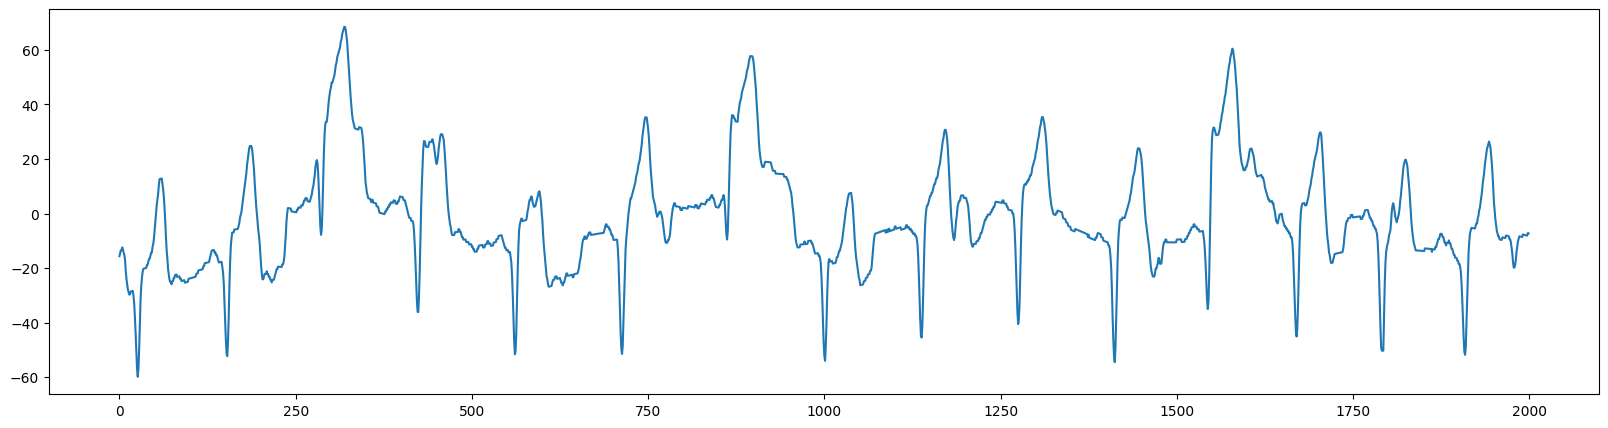

In [ ]:
for i in test_sig:
    plt.rcParams["figure.figsize"] = (20,5)
    plt.plot(i[0:2000])
    plt.show()

### 2.4 Janelamento dos dados de treino

In [ ]:
def discrete_ratio(ratio_set, n):
    classes = list(range(1, n+1))
    ratio = 1.0/n

    for j in range(0, len(ratio_set)):
        for i in range(0, n):
            if ratio_set[j] > ratio*i and ratio_set[j] <= ratio*(i+1):
                ratio_set[j] = int(classes[i])
                break

    return ratio_set

In [ ]:
y = df["output"].copy()
y = discrete_ratio(y, 2)

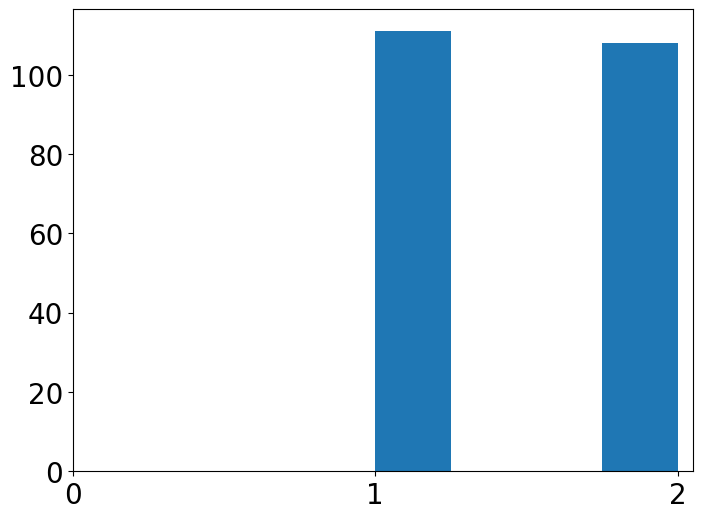

In [ ]:
plt.rcParams.update({'font.size': 20})

y.hist(
    figsize=(8, 6),
    range = [1, 2],
    grid = False,
    bins = 4,
)
plt.xticks(range(3))
plt.show()

In [ ]:
intersection = 100
window_size = 500
interval = 15000
wp_interval = 2
n_windows = "max"

In [ ]:
def window(signal, intersection, window_size, n):
    s_size = len(signal)
    max_n = (s_size-intersection)/(window_size - intersection)
    samples = []

    if  n == "max" or n > max_n:
        n = max_n
        n = math.floor(n)

    max_begin = s_size - (n*(window_size) - (n-1)*intersection) + 1
    init = random.randrange(max_begin)
    for i in range(0, n):
        begin = init + i*window_size - i*intersection
        end = begin + window_size
        samples.append(signal[begin:end])


    return samples

In [ ]:
samples = []

In [ ]:
def random_window(signal, window_size, interval, wp_interval):
  s_size = len(signal)
  n_intervals = math.floor(s_size/interval)

  global samples
  samples = []
  for i in range(0, n_intervals):
    points = []
    begin = i*interval + math.floor(interval/2) - math.floor(window_size/2)

    samples.append(signal[begin:begin+window_size])
    # points = []
    # begin = i*interval
    # end = (i+1)*interval - window_size

    # new_p = random.randrange(begin, end)
    # samples.append(signal[new_p:new_p+window_size])
    # for j in range(wp_interval):
    #   count = 0
    #   while True:
    #     new_p = random.randrange(begin, end)

    #     for point in points:
    #       if new_p + window_size >= point and new_p - window_size <= point:
    #         count += 1
    #         break

    #     if count == 0:
    #       points.append(new_p)
    #       break

    # samples += points

    # for i,x in enumerate(samples):
    #   samples[i] = signal[x:x+window_size]

  return samples




In [ ]:
def embalance_data(df, intersection, window_size, n):

  d_train = df.copy()
  d_train = d_train.iloc[0:0]

  for index, row in df.iterrows():
    samples = window(row["signals"], intersection, window_size, n)

    for k in range(len(samples)):
      d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)

  return d_train

In [ ]:
def random_df(df, window_size, interval, wp_interval):

  d_train = df.copy()
  d_train = d_train.iloc[0:0]

  for index, row in df.iterrows():
    samples = random_window(row["signals"], window_size, interval, wp_interval)

    for k in range(len(samples)):
      d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)

  return d_train

In [ ]:
x_rem, x_test, y_rem, y_test = train_test_split(signals, y, test_size=0.15, stratify=y, random_state=38)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.15, stratify=y_rem, random_state=38)

# d_aux_train = pd.DataFrame({'signals': x_train, 'output': y_train})
# d_train = embalance_data(d_aux_train, intersection, window_size, n_windows)

# d_aux_valid = pd.DataFrame({'signals': x_valid, 'output': y_valid})
# d_valid = embalance_data(d_aux_valid, intersection, window_size, n_windows)

path = 'drive/MyDrive/CNN_Chagas/Chagas/saves/'

d_aux_train = pd.read_hdf(path + 'd_aux_train1.h5')
d_aux_train2 = pd.read_hdf(path + 'd_aux_train2.h5')
d_aux_train = pd.concat([d_aux_train, d_aux_train2])
del d_aux_train2

d_train = pd.read_hdf(path + 'd_train1.h5')
d_train2 = pd.read_hdf(path + 'd_train2.h5')
d_train = pd.concat([d_train, d_train2])
del d_train2

d_aux_valid = pd.read_hdf(path + 'd_aux_valid.h5')
d_valid = pd.read_hdf(path + 'd_valid.h5')

In [ ]:
d_train

,signals,output
0,"[-0.833874, -0.839625, -0.845432, -0.851297, -...",2.0
1,"[-2.547274, -1.555806, -1.564183, -1.572407, -...",2.0
2,"[-2.023976, -2.006236, -1.988543, -1.970897, -...",2.0
3,"[0.632964, 0.611513, 0.590012, -0.431538, -0.4...",2.0
4,"[-7.457822, -6.442039, -5.426243, -4.410436, -...",2.0
...,...,...
598521,"[4.280063, 4.260901, 3.241843, 3.222889, 3.204...",1.0
598522,"[3.74883, 2.74665, 2.744476, 2.742309, 3.74015...",1.0
598523,"[8.334719, 8.343952, 8.352941, 8.361684, 8.370...",1.0
598524,"[-0.695305, 2.295303, 3.286011, 4.27682, 4.267...",1.0


In [ ]:
# def convert_hdf(data, path, n):
#     end = len(data["signals"])
#     step = math.floor(end/n)
#     flag = False
#     count = 0

#     for i in range(0, end, step):
#         count += 1
#         init = i
#         fim = i+step-1

#         val = data.loc[init:fim]
#         val.to_hdf(path + str(count) + '.h5', 'df')
#         print(i)

In [ ]:
# d_aux_train = d_aux_train.reset_index(drop=True)

In [ ]:
# path = 'drive/MyDrive/CNN_Chagas/Chagas/saves/'

# convert_hdf(d_aux_train, path+'d_aux_train', 2)
#convert_hdf(d_train, path+'d_train', 2)


# d_aux_valid.to_hdf(path+'d_aux_valid.h5', 'df')
# d_valid.to_hdf(path+'d_valid.h5', 'df')

In [ ]:
len(d_train)

598526

# 3. Implementação da CNN

### 3.1 Descoberta dos hyperparâmetros (Otimização Bayseana)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from sklearn.utils import shuffle
from math import floor

In [ ]:
d_train.sample(frac=1)
d_valid.sample(frac=1)

,signals,output
55721,"[1.736437, 1.739397, 2.742379, 2.745382, 2.748...",1.0
31591,"[-1.990148, -1.994036, -1.99804, -2.002158, -1...",2.0
33296,"[-3.39206, -4.385746, -4.379405, -4.373037, -4...",2.0
66083,"[-4.966863, -5.00359, -5.04024, -5.076811, -4....",1.0
67399,"[0.907368, 1.922573, 2.937778, 1.952981, 0.968...",1.0
...,...,...
27826,"[0.315358, 0.299256, 0.283242, 1.267316, 1.251...",2.0
60620,"[3.040228, 4.042767, 5.045364, 6.048019, 7.050...",2.0
78635,"[0.111759, 0.113596, 0.115477, 0.117401, 0.119...",1.0
65762,"[1.707864, 1.724754, 1.74174, 2.75882, 3.77599...",1.0


In [ ]:
y_train = d_train["output"].copy()
y_valid = d_valid["output"].copy()

In [ ]:
x_train = np.array(list(d_train["signals"]))
x_valid = np.array(list(d_valid["signals"]))

### 3.1.2 Import packages

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pd.set_option("display.max_columns", None)

from sklearn import metrics
import tensorflow as tf

In [ ]:
!pip install scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/41/6f/53606bacb79e64f30d23410e15f3034447e97a33850d5d4366abdcf7ed84/scikeras-0.11.0-py3-none-any.whl.metadata


In [ ]:
def print_history(history, n):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy ' + str(n))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    # plt.savefig('plot '+classe+'.png')
    plt.show()

In [ ]:
def generate_report(classificador, x_valid, y_valid, columns):
  y_pred = classificador.predict(x_valid)
  y_pred = pd.DataFrame(y_pred)
  y_pred.columns = columns
  y_pred = y_pred.idxmax(axis=1)

  y_valid = pd.DataFrame(y_valid)
  y_valid.columns = columns
  y_valid = y_valid.idxmax(axis=1)

  relatorio = classification_report(y_valid, y_pred)
  print(relatorio)

In [ ]:
def create_cnn(optimizer):

    input_shape = len(x_train[0])
    k1 = 5
    k2 = 3
    n = math.floor(input_shape/(k1+k2-2))
    nn_input = input_shape % (k1+k2-2)

    classificador = Sequential()

    for i  in range(0, 5):
      if i == 0:
        classificador.add(Conv1D(filters=64, kernel_size = k1, input_shape = (input_shape, 1), activation = "relu"))
      else:
          classificador.add(Conv1D(filters=64, kernel_size = k1, activation = "relu"))
      # BatchNormalization()

      classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
      # BatchNormalization()
      # classificador.add(Conv1D(filters=32, kernel_size = k2, activation = "relu"))
      classificador.add(MaxPooling1D(pool_size=2))

    classificador.add(Flatten())

    classificador.add(Dense(units=128, activation='relu'))
    classificador.add(Dropout(0.35))
    classificador.add(Dense(units=64, activation='relu'))
    classificador.add(Dropout(0.35))
    classificador.add(Dense(units=32, activation='relu'))
    classificador.add(Dropout(0.35))
    classificador.add(Dense(units=16, activation='relu'))
    classificador.add(Dropout(0.35))

    classificador.add(Dense(2, activation="softmax"))

    classificador.compile(loss='categorical_crossentropy', optimizer=optimizer(learning_rate=0.001), metrics=["accuracy"])

    return classificador

In [ ]:
class AdaBoost:

    def __init__(self, optimizer):
        self.optimizer = optimizer
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []

    def __not_eq(self, a, b):
      if np.array_equal(a, b):
        return 0
      else:
        return 1

    def __idmax(self, y_pred):
      result = []
      for val in y_pred:
        idx = np.argmax(val)
        aux = np.zeros(len(val))
        aux[idx] = 1
        result.append(aux)

      return np.array(result)

    def __compute_error(self, y, y_pred, w_i):
        error = 0
        for i in range(len(y)):
          error += w_i[i] * self.__not_eq(y[i], y_pred[i])
        error = error/sum(w_i)
        return error

    def __compute_alpha(self, error):
        return np.log((1 - error) / error)

    def __update_weights(self, w_i, alpha, y, y_pred):
        return w_i * np.exp(alpha * (self.__not_eq(y, y_pred)))

    def fit(self, x, y, validation_data=None, M=100, epochs=None, batch_size=None, callbacks=None):

        # Clear before calling
        self.alphas = []
        self.training_errors = []
        self.M = M
        best_acc = []
        best_h = []
        best_G = []

        # Iterate over M weak classifiers
        for m in range(0, M):

            # Set weights for current boosting iteration
            if m == 0:
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # (d) Update w_i
                w_i = self.__update_weights(w_i, alpha_m, y, y_pred)

            # (a) Fit weak classifier and predict labels

            G_m = create_cnn(self.optimizer)

            # if os.path.isfile('_pesos_cnn1d.hdf5') == False:
            #   open('_pesos_cnn1d.hdf5', "x")

            checkpoint = ModelCheckpoint('_pesos_cnn1d.hdf5', monitor="val_accuracy", verbose=1,
                                      save_best_only=True, mode='max')

            history = G_m.fit(x, y, sample_weight = w_i, validation_data=validation_data,
                    epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, callbacks])

            print_history(history, m)

            G_m = load_model('_pesos_cnn1d.hdf5')

            os.remove('_pesos_cnn1d.hdf5')
            # open('_pesos_cnn1d.hdf5', 'w').close()

            #Calcula a acurácia sobre a validação
            y_pred = G_m.predict(validation_data[0])

            idx = np.argmax(y_pred, axis=-1)
            y_pred = np.zeros( y_pred.shape )
            y_pred[ np.arange(y_pred.shape[0]), idx] = 1

            acc= accuracy_score(validation_data[1], y_pred)

            best_acc.append(acc)
            best_h.append(history)
            best_G.append(G_m)


            # if m == 0 or (acc > best_acc):
            #   best_acc = acc
            #   best_G = G_m
            #   best_h = history

            y_pred = G_m.predict(x)
            y_pred = self.__idmax(y_pred)

            self.G_M.append(G_m) # Save to list of weak classifiers

            # (b) Compute error
            error_m = self.__compute_error(y, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Compute alpha
            alpha_m = self.__compute_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.G_M) == len(self.alphas)

        return best_G, best_h, best_acc

    def predict(self, x):

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(x)), columns = range(self.M))

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(x) * self.alphas[m]
            for i in range(weak_preds.shape[0]):
              weak_preds.iloc[i,m] = y_pred_m[i]

        # Calculate final predictions
        y_pred = weak_preds.T.sum()
        y_pred =  self.__idmax(y_pred)

        return y_pred

In [ ]:
# def create_cnn():

#     input_shape = len(x_train[0])
#     k1 = 5
#     k2 = 3
#     n = math.floor(input_shape/(k1+k2-2))
#     nn_input = input_shape % (k1+k2-2)

#     classificador = Sequential()

#     classificador.add(Conv1D(filters=64, kernel_size = k2, input_shape = (input_shape, 1), activation = "relu"))
#     classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
#     classificador.add(MaxPooling1D(pool_size=2))

#     classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
#     classificador.add(Conv1D(filters=64, kernel_size = k2, activation = "relu"))
#     classificador.add(MaxPooling1D(pool_size=2))

#     classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
#     classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
#     classificador.add(MaxPooling1D(pool_size=2))

#     classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
#     classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
#     classificador.add(MaxPooling1D(pool_size=2))

#     classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
#     classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
#     classificador.add(Conv1D(filters=128, kernel_size = k2, activation = "relu"))
#     classificador.add(MaxPooling1D(pool_size=2))

#     classificador.add(Flatten())

#     # classificador.add(Dense(units=256, activation='relu'))
#     # classificador.add(Dropout(0.35))
#     classificador.add(Dense(units=128, activation='relu'))
#     classificador.add(Dropout(0.35))
#     classificador.add(Dense(units=64, activation='relu'))
#     classificador.add(Dropout(0.35))
#     classificador.add(Dense(units=32, activation='relu'))
#     classificador.add(Dropout(0.35))
#     classificador.add(Dense(units=16, activation='relu'))
#     classificador.add(Dropout(0.35))

#     classificador.add(Dense(2, activation="softmax"))

#     classificador.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01), metrics=["accuracy"])

#     return classificador

In [ ]:
def build_adaboost(x_train, y_train, x_valid, y_valid, optimizer):

  print(optimizer)

  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
  y_train = pd.get_dummies(y_train)
  columns = y_train.columns
  y_train = np.array(y_train, dtype=int)

  print(columns)

  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
  y_valid = pd.get_dummies(y_valid)
  y_valid = np.array(y_valid, dtype=int)

  # checkpoint = ModelCheckpoint('_pesos_cnn1d.hdf5', monitor="val_accuracy", verbose=1,
  #                                     save_best_only=True, mode='max')

  es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=0, patience=15)

  adaboost = AdaBoost(optimizer)

  best_G, best_h, best_acc = adaboost.fit(x_train, y_train, validation_data = (x_valid, y_valid),
                         M=1, epochs=150, batch_size=128, callbacks=es)

  generate_report(adaboost, x_valid, y_valid, columns)

  plt.plot(best_acc)
  plt.title("Acurácia de cada modelo")
  plt.show()

  return columns, adaboost

In [ ]:
for optimizer in [Adadelta]:
  columns, adaboost = build_adaboost(x_train, y_train, x_valid, y_valid, optimizer)
# print_history(history, classificador, x_valid, y_valid, columns)

<class 'keras.optimizers.adadelta.Adadelta'>
Float64Index([1.0, 2.0], dtype='float64')
Epoch 1/150
4676/4676 [==============================] - ETA: 0s - loss: 1.2047e-06 - accuracy: 0.5035
Epoch 1: val_accuracy improved from -inf to 0.52177, saving model to _pesos_cnn1d.hdf5
4676/4676 [==============================] - 121s 25ms/step - loss: 1.2047e-06 - accuracy: 0.5035 - val_loss: 0.7019 - val_accuracy: 0.5218
Epoch 2/150
4676/4676 [==============================] - ETA: 0s - loss: 1.1966e-06 - accuracy: 0.5033
Epoch 2: val_accuracy improved from 0.52177 to 0.52182, saving model to _pesos_cnn1d.hdf5
4676/4676 [==============================] - 114s 24ms/step - loss: 1.1966e-06 - accuracy: 0.5033 - val_loss: 0.7011 - val_accuracy: 0.5218
Epoch 3/150
4675/4676 [============================>.] - ETA: 0s - loss: 1.1911e-06 - accuracy: 0.5020
Epoch 3: val_accuracy improved from 0.52182 to 0.52184, saving model to _pesos_cnn1d.hdf5
4676/4676 [==============================] - 114s 24ms/st

In [ ]:
d_aux_test = pd.DataFrame({'signals': x_test, 'output': y_test})
d_test = embalance_data(d_aux_test, intersection, window_size, n_windows)

A saída de streaming foi truncada nas últimas 5000 linhas.
<ipython-input-18-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-18-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-18-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  d_train = d_train.append({'signals': samples[k], 'output': row["output"]}, ignore_index=True)
<ipython-input-18-8d682d9235be>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [ ]:
d_test.sample(frac=1)
y_test = d_test["output"].copy()
x_test = np.array(list(d_test["signals"]))

In [ ]:
model = load_model('_pesos_cnn1d.hdf5')

2577/2577 [==============================] - 17s 3ms/step


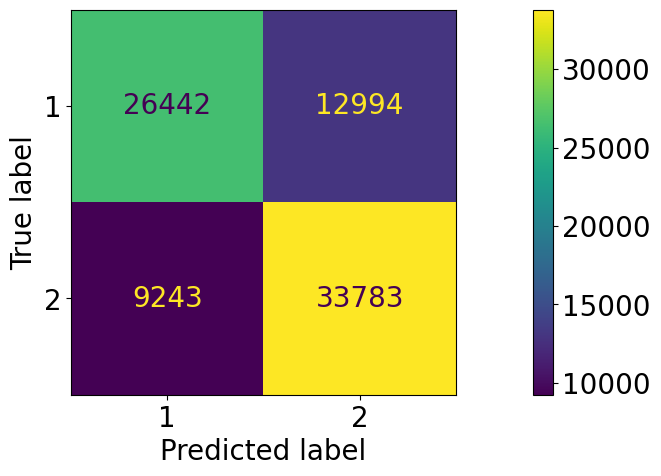

              precision    recall  f1-score   support

           1       0.74      0.67      0.70     39436
           2       0.72      0.79      0.75     43026

    accuracy                           0.73     82462
   macro avg       0.73      0.73      0.73     82462
weighted avg       0.73      0.73      0.73     82462



In [ ]:
y_pred = model.predict(x_valid)

y_pred = pd.DataFrame(y_pred)
y_pred.columns = [1, 2]
y_pred = y_pred.idxmax(axis=1)

y_te = pd.DataFrame(y_valid)

cf_matrix = confusion_matrix(y_te, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()
plt.show()

relatorio = classification_report(y_te, y_pred, target_names = ['1','2'])
print(relatorio)

4149/4149 [==============================] - 12s 3ms/step


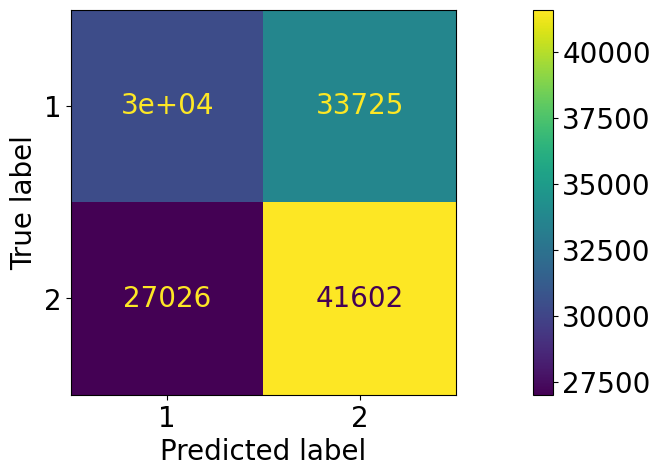

              precision    recall  f1-score   support

           1       0.53      0.47      0.50     64137
           2       0.55      0.61      0.58     68628

    accuracy                           0.54    132765
   macro avg       0.54      0.54      0.54    132765
weighted avg       0.54      0.54      0.54    132765



In [ ]:
y_pred = model.predict(x_test)

y_pred = pd.DataFrame(y_pred)
y_pred.columns = [1, 2]
y_pred = y_pred.idxmax(axis=1)

y_te = pd.DataFrame(y_test)

cf_matrix = confusion_matrix(y_te, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()
plt.show()

relatorio = classification_report(y_te, y_pred, target_names = ['1','2'])
print(relatorio)

In [ ]:
y_te

,output
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
82457,1.0
82458,1.0
82459,1.0
82460,1.0


In [ ]:
y_pred = []
for signal in d_aux_valid["signals"]:
  samples = window(signal, intersection, window_size, "max")
  samples = np.array(samples)
  samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

  prediction = adaboost.predict(samples)
  prediction = pd.DataFrame(prediction)
  prediction.columns = ['1', '2']
  prediction = prediction.idxmax(axis=1)
  val = prediction.mode()[0]
  y_pred.append(val)

A saída de streaming foi truncada nas últimas 5000 linhas.
144/144 [==============================] - 0s 3ms/step


In [ ]:
y_pred = pd.DataFrame(y_pred)

ValueError: ignored

In [ ]:
y_val = [str(int(i)) for i in d_aux_valid["output"]]
y_val = pd.DataFrame(y_val)

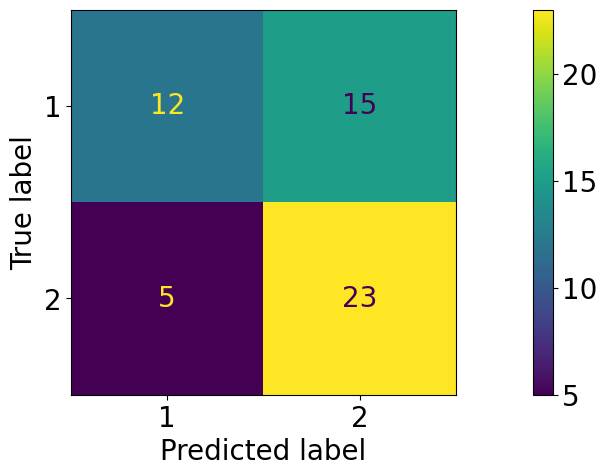

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

plt.rcParams['figure.figsize']=(20,5)
plt.rcParams.update({'font.size': 20})

cf_matrix = confusion_matrix(y_val, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = ['1','2'])
cm_display.plot()

In [ ]:
from sklearn.metrics import classification_report

relatorio = classification_report(y_val, y_pred, target_names = ['1','2'])
print(relatorio)

              precision    recall  f1-score   support

           1       0.71      0.44      0.55        27
           2       0.61      0.82      0.70        28

    accuracy                           0.64        55
   macro avg       0.66      0.63      0.62        55
weighted avg       0.65      0.64      0.62        55



In [ ]:
def build_tree(x_train, y_train, x_valid, y_valid, classes_array, father):

  if len(classes_array) < 2:
    print("impossivel classificar")
    return

  minority = classes_array[0]
  del classes_array[0]

  if len(classes_array) != 1:
    y_next = y_train.replace(classes_array, "nan")
    y_next_val = y_valid.replace(classes_array, "nan")
  else:
    y_next = y_train
    y_next_val = y_valid

  columns, model, history = create_cnn(x_train, y_next, x_valid, y_next_val)
  node = BinaryTreeNode(model=model, classe="nan")
  node.leftChild = BinaryTreeNode(model=None, classe=minority)
  node.columns = columns

  print_history(history, minority, model, x_valid, y_next_val, columns)

  if type(father) == RootNode:
    father.child = node
  else:
    father.rightChild = node

  if len(classes_array) == 1:
    node.rightChild = BinaryTreeNode(model=None, classe=classes_array[0])
  else:
    aux_df = pd.DataFrame({"signals": list(x_train), "classes": y_train})
    aux_df_valid = pd.DataFrame({"signals": list(x_valid), "classes": y_valid})

    aux_df.drop(aux_df[aux_df['classes'] == minority].index, inplace=True)
    aux_df_valid.drop(aux_df_valid[aux_df_valid['classes'] == minority].index, inplace=True)

    x_next = np.array(list(aux_df["signals"]))
    x_next_val = np.array(list(aux_df_valid["signals"]))

    y_next = aux_df["classes"]
    y_next_val = aux_df_valid["classes"]

    build_tree(x_next, y_next, x_next_val, y_next_val, classes_array, node)


# 4. Verificando  a precisão com os dados de teste

In [ ]:
y_pred = []
for signal in x_test:
  samples = window(signal, intersection, window_size, "max")
  samples = np.array(samples)
  samples = samples.reshape(samples.shape[0],samples.shape[1], 1)

  prediction = model.predict(samples)
  val = prediction.mean()
  y_pred.append(val)

In [ ]:
print(mean_squared_error(y_test, y_pred))

In [ ]:
x1 = range(0, len(y_test))
x2 = range(0, len(y_pred))

test = plt.scatter(x1, y_test, s = 70)
pred = plt.scatter(x2, y_pred, s = 70)

plt.legend((test, pred),
            ("Real", "Predito"),
            loc='lower left',
        )

plt.savefig("result.png")